##### https://medium.com/@jonathan_hui/rl-trust-region-policy-optimization-trpo-explained-a6ee04eeeee9

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np
import gym

In [2]:
env = gym.make('CartPole-v1')

assert isinstance(env.observation_space, gym.spaces.Box)
assert isinstance(env.action_space, gym.spaces.Discrete)

In [3]:
SEED = 1234

env.seed(SEED);
np.random.seed(SEED);
torch.manual_seed(SEED);

In [4]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout = 0.25):
        super().__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.fc_1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.fc_2(x)
        return x

In [5]:
INPUT_DIM = env.observation_space.shape[0]
HIDDEN_DIM = 128
OUTPUT_DIM = env.action_space.n

actor = MLP(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)
critic = MLP(INPUT_DIM, HIDDEN_DIM, 1)

In [6]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0)
        
actor.apply(init_weights)
critic.apply(init_weights)

MLP(
  (fc_1): Linear(in_features=4, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.25)
)

In [7]:
LEARNING_RATE = 0.01

actor_optimizer = optim.Adam(actor.parameters(), lr = LEARNING_RATE)
critic_optimizer = optim.Adam(critic.parameters(), lr = LEARNING_RATE)

In [8]:
def train(env, actor, critic, actor_optimizer, critic_optimizer, discount_factor, ppo_steps, ppo_clip):
        
    states = []
    actions = []
    log_prob_actions = []
    values = []
    rewards = []
    done = False
    episode_reward = 0

    state = env.reset()

    while not done:

        state = torch.FloatTensor(state).unsqueeze(0)

        #append state here, not after we get the next state from env.step()
        states.append(state)
        
        action_pred = actor(state)
        value_pred = critic(state)
                
        action_prob = F.softmax(action_pred, dim = -1)
                
        dist = distributions.Categorical(action_prob)
        
        action = dist.sample()
        
        log_prob_action = dist.log_prob(action)
        
        state, reward, done, _ = env.step(action.item())

        actions.append(action)
        log_prob_actions.append(log_prob_action)
        values.append(value_pred)
        rewards.append(reward)
        
        episode_reward += reward
    
    states = torch.cat(states)
    actions = torch.cat(actions)    
    log_prob_actions = torch.cat(log_prob_actions)
    values = torch.cat(values).squeeze(-1)
    
    returns = calculate_returns(rewards, discount_factor)
    advantages = calculate_advantages(returns, values)
    
    policy_loss, value_loss = update_policy(actor, critic, states, actions, log_prob_actions, advantages, returns, actor_optimizer, critic_optimizer, ppo_steps, ppo_clip)

    return policy_loss, value_loss, episode_reward

In [9]:
def calculate_returns(rewards, discount_factor, normalize = True):
    
    returns = []
    R = 0
    
    for r in reversed(rewards):
        R = r + R * discount_factor
        returns.insert(0, R)
        
    returns = torch.tensor(returns)
    
    if normalize:
        returns = (returns - returns.mean()) / returns.std()
        
    return returns

In [10]:
def calculate_advantages(returns, values, normalize = True):
    
    advantages = []
    
    for r, v in zip(reversed(returns), reversed(values)):
        advantage = r - v
        advantages.insert(0, advantage)
        
    advantages = torch.tensor(advantages)
    
    if normalize:
        advantages = (advantages - advantages.mean()) / advantages.std()
        
    return advantages

In [11]:
def update_policy(actor, critic, states, actions, log_prob_actions, advantages, returns, actor_optimizer, critic_optimizer, ppo_steps, ppo_clip):
    
    total_policy_loss = 0 
    total_value_loss = 0
    
    log_prob_actions = log_prob_actions.detach()
    actions = actions.detach()
    
    for _ in range(ppo_steps):
                
        #get new log prob of actions for all input states
        action_pred = actor(states)
        values = critic(states).squeeze(-1)
        action_prob = F.softmax(action_pred, dim = -1)
        dist = distributions.Categorical(action_prob)
        
        #new log prob using old actions
        new_log_prob_actions = dist.log_prob(actions)
        
        policy_ratio = (new_log_prob_actions - log_prob_actions).exp()
                
        policy_loss_1 = policy_ratio * advantages
        policy_loss_2 = torch.clamp(policy_ratio, min = 1.0 - ppo_clip, max = 1.0 + ppo_clip) * advantages
        
        policy_loss = - torch.min(policy_loss_1, policy_loss_2).mean()
        
        value_loss = F.smooth_l1_loss(returns, values).mean()
    
        actor_optimizer.zero_grad()
        critic_optimizer.zero_grad()

        policy_loss.backward()
        value_loss.backward()

        actor_optimizer.step()
        critic_optimizer.step()
    
        total_policy_loss += policy_loss.item()
        total_value_loss += value_loss.item()
    
    return total_policy_loss / ppo_steps, total_value_loss / ppo_steps

In [12]:
MAX_EPISODES = 500
DISCOUNT_FACTOR = 0.99
N_TRIALS = 25
REWARD_THRESHOLD = 475
PRINT_EVERY = 10
PPO_STEPS = 5
PPO_CLIP = 0.2

episode_rewards = []

for episode in tqdm(range(1, MAX_EPISODES+1)):
    
    policy_loss, value_loss, episode_reward = train(env, actor, critic, actor_optimizer, critic_optimizer, DISCOUNT_FACTOR, PPO_STEPS, PPO_CLIP)
    
    episode_rewards.append(episode_reward)
    
    mean_trial_rewards = np.mean(episode_rewards[-N_TRIALS:])
    
    if episode % PRINT_EVERY == 0:
    
        print(f'| Episode: {episode:4} | Mean Rewards: {mean_trial_rewards:6.2f} |')
    
    if mean_trial_rewards >= REWARD_THRESHOLD:
        
        print(f'Reached reward threshold in {episode} episodes')
        
        break

| Episode:   10 | Mean Rewards:  32.00 |
| Episode:   20 | Mean Rewards:  37.25 |
| Episode:   30 | Mean Rewards:  46.92 |
| Episode:   40 | Mean Rewards:  73.12 |
| Episode:   50 | Mean Rewards: 127.88 |
| Episode:   60 | Mean Rewards: 202.24 |
| Episode:   70 | Mean Rewards: 295.88 |
| Episode:   80 | Mean Rewards: 416.52 |
| Episode:   90 | Mean Rewards: 462.76 |
| Episode:  100 | Mean Rewards: 471.76 |
| Episode:  110 | Mean Rewards: 439.80 |
| Episode:  120 | Mean Rewards: 433.24 |
| Episode:  130 | Mean Rewards: 472.60 |
Reached reward threshold in 131 episodes


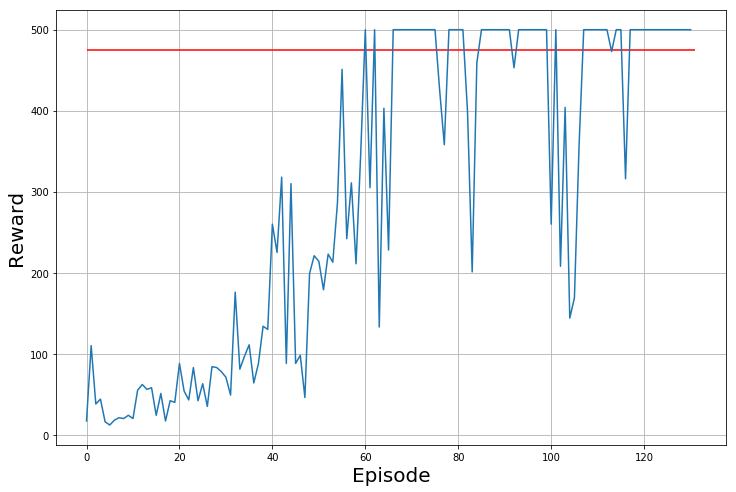

In [13]:
plt.figure(figsize=(12,8))
plt.plot(episode_rewards)
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Reward', fontsize=20)
plt.hlines(REWARD_THRESHOLD, 0, len(episode_rewards), color='r')
plt.grid()